# Training Custom Resnet on FastAI Imagenette

In [1]:
from importlib.util import find_spec
if find_spec("model") is None:
    import sys
    sys.path.append('..')

In [2]:
from model.backbone.resnet import ResNet50

## Build DataLoaders

Following [Fast AI Tutorial](https://docs.fast.ai/tutorial.imagenette)

In [3]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [4]:
path = untar_data(URLs.IMAGENETTE)

### Using FastAI Factory Method to Load Dataset

In [5]:
dls = ImageDataLoaders.from_folder(path, valid='val',
                                   item_tfms=RandomResizedCrop(128, min_scale=0.35),
                                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                                  )

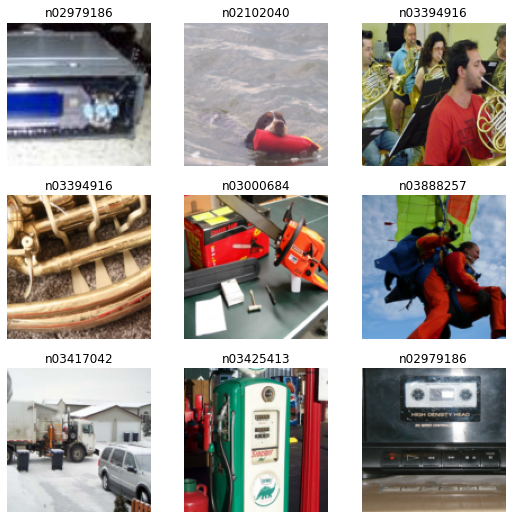

In [6]:
dls.show_batch()

### Using FastAI Data Block API to Load Dataset

In [7]:
fnames = get_image_files(path)

In [8]:
dblock = DataBlock()

In [9]:
dsets = dblock.datasets(fnames)
dsets.train[0]

(Path('/home/kmh/.fastai/data/imagenette2/train/n03445777/n03445777_755.JPEG'),
 Path('/home/kmh/.fastai/data/imagenette2/train/n03445777/n03445777_755.JPEG'))

In [10]:
dblock = DataBlock(get_items = get_image_files)

In [11]:
dsets = dblock.datasets(path)
dsets.train[0]

(Path('/home/kmh/.fastai/data/imagenette2/train/n03000684/n03000684_17587.JPEG'),
 Path('/home/kmh/.fastai/data/imagenette2/train/n03000684/n03000684_17587.JPEG'))

In [12]:
parent_label(fnames[0])

'n02102040'

In [4]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [5]:
def label_func(fname):
    return lbl_dict[parent_label(fname)]

In [15]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=label_func,
    splitter=GrandparentSplitter(),
    item_tfms=RandomResizedCrop(128, min_scale=0.35),
    batch_tfms=Normalize.from_stats(*imagenet_stats)
    )
dsets = dblock.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=500x375, TensorCategory(0))

In [16]:
dsets.vocab

(#10) ['English springer','French horn','cassette player','chain saw','church','garbage truck','gas pump','golf ball','parachute','tench']

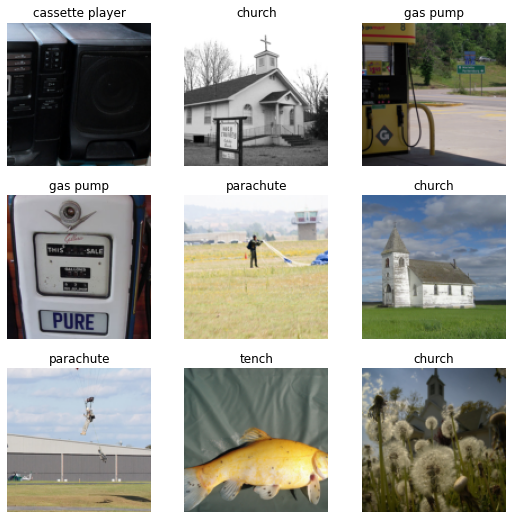

In [17]:
dls = dblock.dataloaders(path)
dls.show_batch()

## Using FastAPI's Mid-Level API to Load the Data

In [6]:
source = untar_data(URLs.IMAGENETTE_160)
fnames = get_image_files(source)

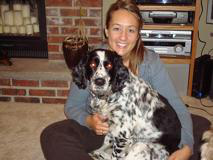

In [7]:
PILImage.create(fnames[0])

In [8]:
lbl_dict[parent_label(fnames[0])]

'English springer'

In [9]:
tfm = Pipeline([parent_label, lbl_dict.__getitem__, Categorize(vocab=lbl_dict.values())])
tfm(fnames[0])

TensorCategory(0)

In [10]:
splits = GrandparentSplitter(valid_name='val')(fnames)

In [11]:
dsets = Datasets(fnames, [[PILImage.create], tfm], splits=splits)

In [12]:
dsets[0]

(PILImage mode=RGB size=213x160, TensorCategory(0))

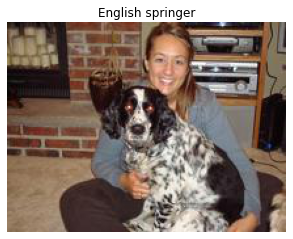

In [13]:
dsets.show(dsets[0]);

In [14]:
item_tfms = [ToTensor, RandomResizedCrop(224, min_scale=0.35)]

In [15]:
batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]

In [16]:
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64, num_workers=1)

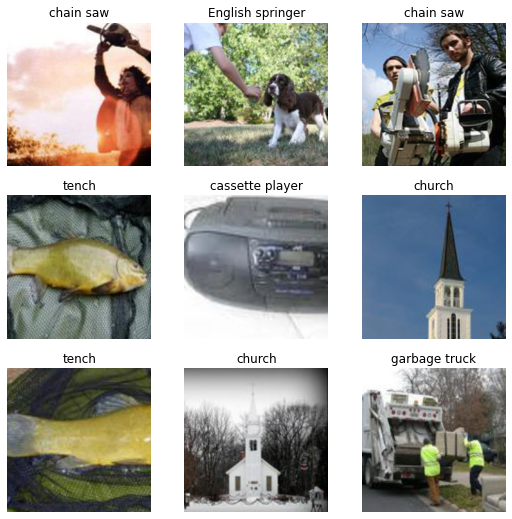

In [17]:
dls.show_batch()

## Training The Model

Using FastAI's Own ResNet Model As Baseline.

In [30]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, pretrained=False)

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.001737800776027143)

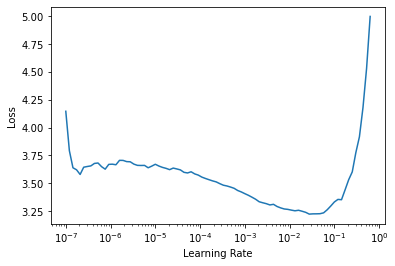

In [31]:
learn.lr_find()

In [32]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.583020,2.350806,0.311083,00:31
1,1.932188,2.203403,0.394395,00:32
2,1.618565,1.836344,0.404331,00:31
3,1.324143,1.317288,0.605860,00:32
4,1.144473,1.018897,0.687134,00:32


In [33]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy)

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=0.0006918309954926372)

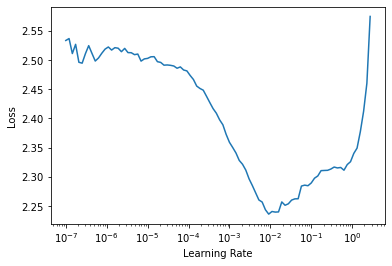

In [34]:
learn.lr_find()

In [35]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.828153,1.644653,0.461656,00:35
1,1.337268,1.206478,0.614522,00:35
2,1.066167,1.061462,0.662675,00:35
3,0.891281,0.876011,0.728153,00:35
4,0.797870,0.837476,0.740382,00:35


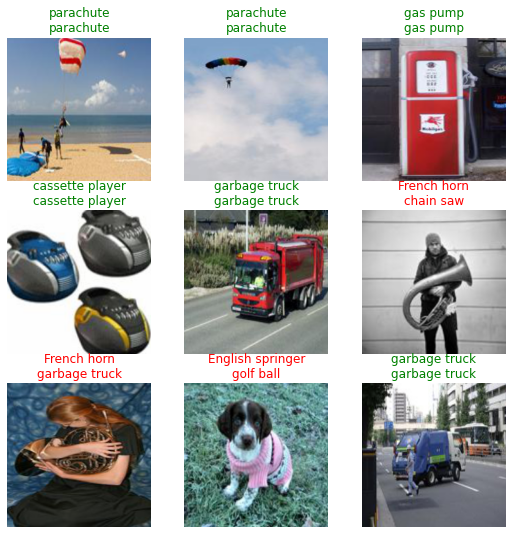

In [36]:
learn.show_results()

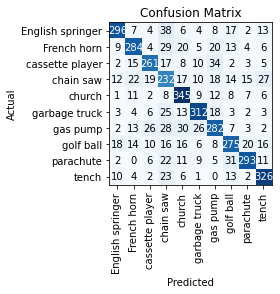

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title="Confusion Matrix")

Using own model with Xavier Normal Init for Linear Layer

In [18]:
learn = Learner(dls, ResNet50(num_classes=10), metrics=accuracy, pretrained=False)

../model/backbone/resnet.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.fc(out))


SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=1.5848932266235352)

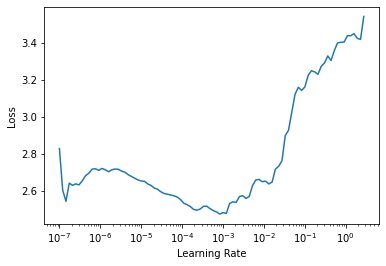

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(4, 3e-6)

epoch,train_loss,valid_loss,accuracy,time
0,2.399457,2.292421,0.152357,01:00
1,2.159214,2.139052,0.250446,01:00
2,2.085779,2.091097,0.276178,01:01
3,2.065543,2.071860,0.294522,01:01


../model/backbone/resnet.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.fc(out))


SuggestedLRs(lr_min=1.0964782268274575e-05, lr_steep=0.5248074531555176)

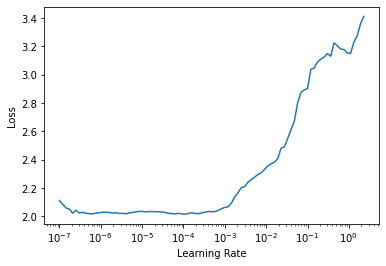

In [21]:
learn.lr_find()

Using own model with Normal Init (std=0.01) for Linear Layer

In [18]:
learn = Learner(dls, ResNet50(num_classes=10), metrics=accuracy, pretrained=False)

../model/backbone/resnet.py:108: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.fc(out))


SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=1.3182567358016968)

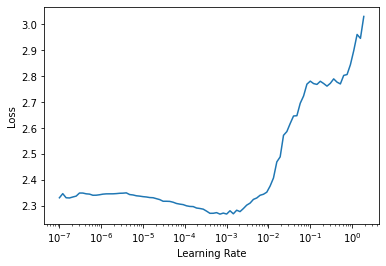

In [19]:
learn.lr_find()

In [ ]:

learn.fit_one_cycle(4, 3e-6)

Using PyTorch ResNet Inits.

In [19]:
learn = Learner(dls, ResNet50(num_classes=10), loss_func=F.nll_loss, metrics=accuracy, pretrained=False)

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=0.2089296132326126)

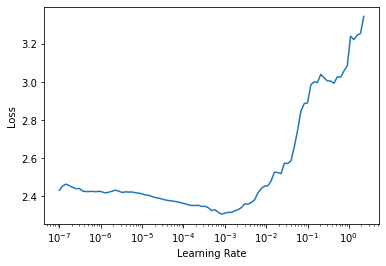

In [20]:
learn.lr_find()

Using FastAI XResNet Init.

In [18]:
learn = Learner(dls, ResNet50(num_classes=10), loss_func=F.nll_loss, metrics=accuracy, pretrained=False)

SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=6.30957365501672e-05)

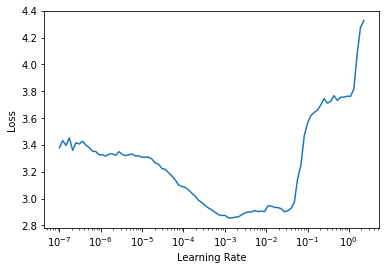

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(4, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.041634,3.046450,0.230064,01:01
1,1.592707,1.743295,0.461911,01:01
2,1.225930,1.161230,0.629554,01:01
3,0.955589,0.952006,0.696561,01:01
